In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'ee77b8a5584e40a1a872154d8a42788c')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [18]:
results = search_images_bing(key, 'tshirt')
ims = results.attrgot('contentUrl')
len(ims)

150

In [19]:
dest = 'images/tshirts.jpg'
download_url(ims[0], dest)

Path('images/tshirts.jpg')

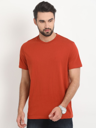

In [20]:
im = Image.open(dest)
im.to_thumb(128,128)

This seems to have worked nicely, so let's use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder:

In [21]:
tshirt_types = 'sleeveless','long sleeve','short sleeve'
path = Path('tshirts')

In [22]:
if not path.exists():
    path.mkdir()
    for o in tshirt_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} tshirt')
        download_images(dest, urls=results.attrgot('contentUrl'))

Our folder has image files, as we'd expect:

In [23]:
fns = get_image_files(path)
fns

(#438) [Path('tshirts/sleeveless/7c2cc737-0c60-4aee-9abb-8a1621aa2009.jpg'),Path('tshirts/sleeveless/81d0cde2-91f9-4e66-8fd7-18dc5e7edb04.jpg'),Path('tshirts/sleeveless/666ee464-d1a0-413f-8f41-8374e558afd1.jpg'),Path('tshirts/sleeveless/f2d308d7-7084-466d-8f13-77e749db114e.jpeg'),Path('tshirts/sleeveless/1e6322ac-6c55-4b50-92da-efd7f90a029b.jpg'),Path('tshirts/sleeveless/6043c4cf-342f-46ec-8f50-f2cd6cedfab2.jpg'),Path('tshirts/sleeveless/2af12930-a139-4ef2-9088-95643c5d3e9b.jpg'),Path('tshirts/sleeveless/06e0518c-b2ef-4aba-8b21-5f947df03cee.jpg'),Path('tshirts/sleeveless/b68f7b86-46d7-4c87-a431-cc1340722ec0.jpg'),Path('tshirts/sleeveless/84c67ec8-f499-4648-888f-06f55d60133c.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [24]:
failed = verify_images(fns)
failed

(#3) [Path('tshirts/long sleeve/c7e17d6d-67bb-4be2-8db1-3280c218ef86.jpg'),Path('tshirts/long sleeve/eea1d3cb-f6ee-4382-875d-5768347534eb.jpg'),Path('tshirts/short sleeve/7e7250e9-3e8d-4418-85f3-4ca281b735ec.jpg')]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [25]:
failed.map(Path.unlink);

In [26]:
tshirts = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [27]:
dls = tshirts.dataloaders(path)

/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


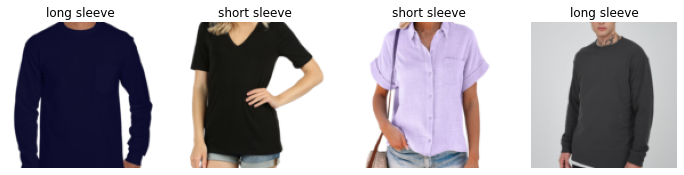

In [28]:
dls.valid.show_batch(max_n=4, nrows=1)

### Data Augmentation

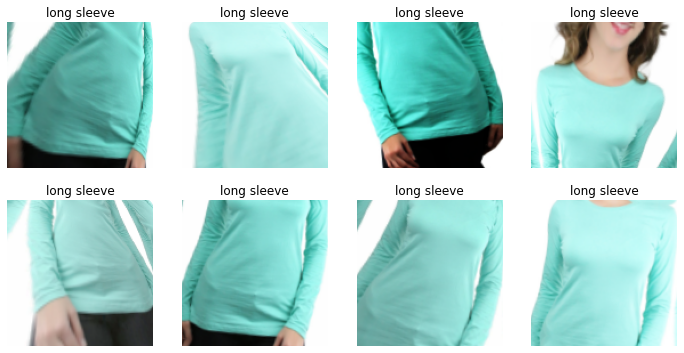

In [29]:
tshirts = tshirts.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = tshirts.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

In [30]:
tshirts = tshirts.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = tshirts.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [31]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.855380,0.934085,0.436782,00:09


epoch,train_loss,valid_loss,error_rate,time
0,1.140916,0.668550,0.264368,00:10
1,0.973759,0.356827,0.172414,00:10
2,0.781556,0.251690,0.091954,00:11
3,0.663083,0.260814,0.091954,00:10


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

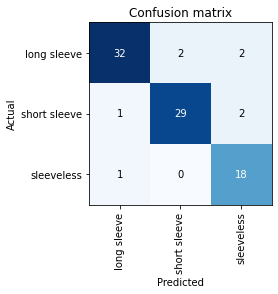

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

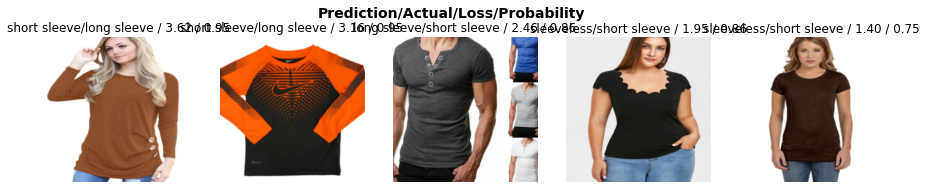

In [33]:
interp.plot_top_losses(5, nrows=1)

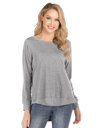

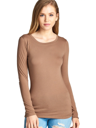

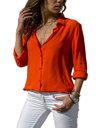

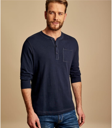

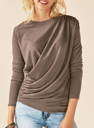

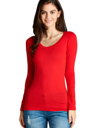

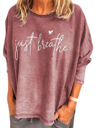

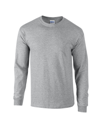

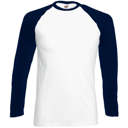

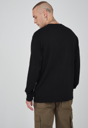

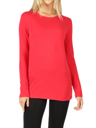

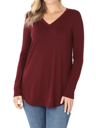

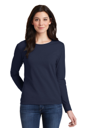

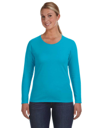

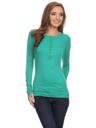

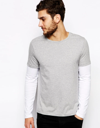

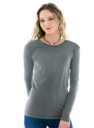

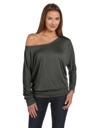

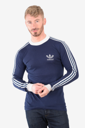

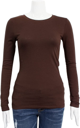

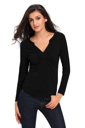

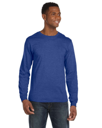

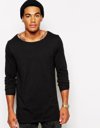

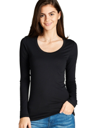

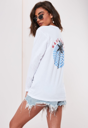

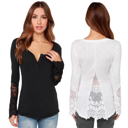

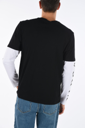

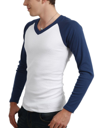

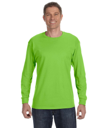

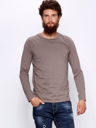

In [34]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

<img alt="Cleaner widget" width="700" src="images/att_00007.png">

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

In [36]:
learn.export()

In [37]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [38]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [ ]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([9.0767e-06, 9.9999e-01, 1.5748e-07]))

In [ ]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']

In [39]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" src="images/att_00008.png">

Now we can grab the image:

In [42]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/tshirts.jpg'])

In [44]:
img = PILImage.create(btn_upload.data[-1])

<img alt="Output widget representing the image" width="117" src="images/att_00009.png">

We can use an `Output` widget to display it:

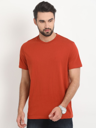

Output()

In [45]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

<img alt="Output widget representing the image" width="117" src="images/att_00009.png">

Then we can get our predictions:

In [46]:
pred,pred_idx,probs = learn_inf.predict(img)

and use a `Label` to display them:

In [47]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: short sleeve; Probability: 0.9820')

`Prediction: grizzly; Probability: 1.0000`

We'll need a button to do the classification. It looks exactly like the upload button:

In [48]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a *click event handler*; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [49]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [50]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [51]:
#hide_output
VBox([widgets.Label('Select your tshirt!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

<img alt="The whole widget" width="233" src="images/att_00011.png">

### Turning Your Notebook into a Real App

In [53]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.3/111.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: jupyter-core
    Found existing installation: jupyter-core 4.10.0
    Uninstalling jupyter-core-4.10.0:
      Successfully uninstalled jupyter-core-4.10.0
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.6.4
    Uninstalling nbclient-0.6.4:
      Successfully uninstalled nbclient-0.6.4
Enabling: voila
- Writing config: /root/mambaforge/etc/jupyter
    - Validating...
      voila 0.3.6 OK
